# 04_02.Decision Tree(분류)


## 1.기본 package 설정

In [ ]:
# 그래프에서 한글 폰트 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

#  *** 런타임 다시 시작

In [ ]:
## 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

## 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

## 3.데이터 전처리
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline                    # 불균형데이터 처리를 위한 pipeline 수정
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# 4. 훈련/검증용 데이터 분리
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE                  # 불균형데이터 처리로 수정

## 5.모델구축
# from sklearn.tree import DecisionTreeRegressor, plot_tree # 결정 트리(예측)
from sklearn.tree import DecisionTreeClassifier, plot_tree # 결정 트리(분류)

## 6.모델검정
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import ConfusionMatrixDisplay # 그래프 그리기기
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score  # 정확도, 민감도 등
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

# 7.최적화
from sklearn.model_selection import GridSearchCV # 하이퍼파라미터 튜닝

## 2.데이터 불러오기

### 2.1 구글 드라이브와 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 데이터 프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [ ]:
breast_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/유방암진단.csv', encoding="cp949")
breast_df.head()

,id,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,1,1,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,2,1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,3,1,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,4,0,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,5,0,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


### 2.3 자료구조 살펴보기

In [ ]:
breast_df.shape

In [ ]:
breast_df.info()

In [ ]:
breast_df.columns

## 3.데이터 전처리

### 3.1 필요없는 변수 제거

In [ ]:
breast_df = breast_df.drop (['id'], axis=1)
breast_df.head()

,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,1,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,1,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,0,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,0,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


### 3.2 범주형 변수 처리
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [ ]:
breast_df['진단'] = breast_df['진단'].replace ([1,0], ['악성','양성'])  # 중요한 변수를 앞으로 변경

breast_df.head()

,진단,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,악성,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,악성,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,악성,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,양성,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,양성,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


In [ ]:
breast_df.info()

## 4.데이터 탐색

### 4.1 EDA 데이터 탐색

In [ ]:
# 수치형 변수
breast_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
반지름,565.0,14.14,3.53,7.00,11.70,13.40,15.90,28.10
질감,565.0,19.29,4.31,9.70,16.20,18.80,21.80,39.30
주변부,565.0,92.03,24.37,43.80,75.20,86.30,104.30,188.50
크기,565.0,655.84,352.94,143.50,419.80,551.10,788.50,2501.00
평활도,565.0,0.10,0.01,0.05,0.09,0.10,0.10,0.16
조밀성,565.0,0.10,0.05,0.02,0.06,0.09,0.13,0.34
오목,565.0,0.09,0.08,0.00,0.03,0.06,0.13,0.43
대칭,565.0,0.18,0.03,0.11,0.16,0.18,0.20,0.30
프랙탈,565.0,0.06,0.01,0.05,0.06,0.06,0.07,0.10


In [ ]:
# 그룹별 분석
breast_df.groupby('진단').mean()

In [ ]:
# 범주형 변수
# lecture_df.columns
categorical_features=['진단']

for col in categorical_features:
    cat = breast_df[col].value_counts()
    print(cat)

### 4.2 그래프 그리기

In [ ]:
# 한글 폰트 인식
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 수치형 변수
g = sns.pairplot(breast_df,
                 hue="진단",
                 markers=["o", "s"])

In [ ]:
# 범주형 변수
for col in categorical_features:
    sns.countplot(x=col, data = breast_df)
    plt.show()

### 4.3 base accuracy


In [ ]:
# base accuracy
breast_df['진단'].value_counts()

In [ ]:
breast_df['진단'].value_counts()/breast_df.shape[0]

## 5.훈련/테스트용 데이터 분할


### 5.1 data와 target으로 분리
- data: X, target: y 로 분리

- X 추출


In [ ]:
X = breast_df.drop (['진단'], axis=1)
X.head()

,반지름,질감,주변부,크기,평활도,조밀성,오목,대칭,프랙탈
0,18.0,10.4,122.8,1001.0,0.118,0.278,0.300,0.242,0.079
1,20.6,17.8,132.9,1326.0,0.085,0.079,0.087,0.181,0.057
2,19.7,21.3,130.0,1203.0,0.110,0.160,0.197,0.207,0.060
3,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058
4,13.1,15.7,85.6,520.0,0.108,0.127,0.046,0.197,0.068


- target(y) 추출
- y 값을 series에서 배열로 변환

In [ ]:
y = breast_df['진단']
y.head()

0    악성
1    악성
2    악성
3    양성
4    양성
Name: 진단, dtype: object

In [ ]:
# y 값을 배열로 변환
# 악성 -> 0, 양성 -> 1로 변경됨

class_le = LabelEncoder()
y = class_le.fit_transform(y)
y

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

### 5.2 훈련용 및 테스트용 데이터 분할
- test_size: 검증데이터 30%
- random_state : random seed 번호 = 1
- stratify : y(클래스)의 비율에 따라 분할(분류모형일때 사용)

In [ ]:
# \ 이후에 space 없어야 함
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 1,
                                                    stratify = y)        # stratify(분류모형일때 사용)

In [ ]:
X_train.info()

In [ ]:
np.bincount(y_train)

array([145, 250])

In [ ]:
X_test.info()

In [ ]:
np.bincount(y_test)

array([ 63, 107])

## 6.pipeline으로 데이터 전처리
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- R에서 recipe
- 범주형 변수: OneHotEncoder
- 수치형 변수:
- 선형모델은 StandardScaler 로 표준화
- tree형 모델은 데이터 원형 사용

### 6.1 preprocess 세팅

In [ ]:
# from imblearn.pipeline import Pipeline
# 불균형데이터 처리를 위해 from sklearn.pipeline-> from imblearn.pipeline

In [ ]:
# pipeline으로 세팅
# 수치형 변수(y는 제외)
numeric_features = ['반지름', '질감', '주변부', '크기', '평활도', '조밀성', '오목', '대칭', '프랙탈']

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), # 누락된 값은 중앙값으로 처리
        #('scaler', StandardScaler())                # tree형 모델은 데이터 원형 사용
    ]
)

# 범주형 변수(y는 제외)
categorical_features=[]

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant',
                                  fill_value='missing')),  # 누락된 값은 missing으로 상수 처리
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# preprocessor로 데이터 변환 세팅
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['반지름', '질감', '주변부', '크기', '평활도', '조밀성', '오목',
                                  '대칭', '프랙탈']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

### 6.2 데이터 전처리 결과 확인
- https://www.kaggle.com/code/thomasswain/titanic-classifier

In [ ]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head()

,0,1,2,3,4,5,6,7,8
0,12.8,17.5,83.1,508.3,0.080,0.089,0.074,0.157,0.058
1,7.7,25.5,48.0,178.8,0.081,0.049,0.000,0.187,0.073
2,11.3,13.0,72.2,388.0,0.098,0.076,0.033,0.177,0.063
3,11.0,16.8,70.9,373.2,0.108,0.078,0.030,0.171,0.063
4,13.5,14.4,87.5,566.3,0.098,0.081,0.067,0.189,0.058


## 7.모델만들기 (모델 설정)
- R에서 workflow
- 예측모델: 000_reg
- 분류모델: 000_clf

### 7.1 pipeline으로 모델 연결

In [ ]:
#from imblearn.over_sampling import SMOTE                  # 불균형데이터 처리로 수정

dt_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ('smote', SMOTE(sampling_strategy=0.75)),
        ("dt_clf", DecisionTreeClassifier())                                 # dt_reg --> dt_clf
    ]
)

dt_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['반지름', '질감', '주변부', '크기',
                                                   '평활도', '조밀성', '오목', '대칭',
                                                   '프랙탈']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy=0.75)),
                ('dt_clf', DecisionTreeClassifier())])

### 7.2 하이퍼파라미터 세팅
- 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝
- 기계학습 모델의 성능을 결정하는 하이퍼 파라미터 튜닝

In [ ]:
dt_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'smote', 'dt_clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__keep_empty_features', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__imputer', 'preprocessor__cat__encoder', 'preprocessor__cat__imputer__add_indicator', 'preprocessor__cat__imputer__copy', 'preprocessor__cat

In [ ]:
dt_grid = {
    "dt_clf__ccp_alpha" :np.logspace(-5,-3,3) ,     # [1.e-05, 1.e-04, 1.e-03]
    'dt_clf__max_depth': [1, 3, 5, 7],
    'dt_clf__min_samples_leaf': [10, 30, 50],
}

dt_grid

{'dt_clf__ccp_alpha': array([1.e-05, 1.e-04, 1.e-03]),
 'dt_clf__max_depth': [1, 3, 5, 7],
 'dt_clf__min_samples_leaf': [10, 30, 50]}

### 7.3 하이퍼파라미터 그리드 만들기

In [ ]:
dt_gs = GridSearchCV(estimator = dt_pipe,
                       param_grid = dt_grid,
                       scoring='roc_auc',             # roc_auc
                       cv = 10,
                       n_jobs = -1,
                       verbose = 10,              # 프로세스 진행사항 확인
                       return_train_score = True) # 훈련결과 저장

## 8.모델 훈련(모델 학습)
- machine learning

### 8.1 모델 훈련하기(learning)

In [ ]:
dt_gs.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['반지름',
                                                                          '질감',
                                                                          '주변부',
                                                                          '크기',
                                                                          '평활도',
                                                                          '조밀성',
                                                                          '오목',
                                                                          '대칭',
                                                                          '프랙탈']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('smote', SMOTE(sampling_strategy=0.75)),
                                       ('dt_clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt_clf__ccp_alpha': array([1.e-05, 1.e-04, 1.e-03]),
                         'dt_clf__max_depth': [1, 3, 5, 7],
                         'dt_clf__min_samples_leaf': [10, 30, 50]},
             return_train_score=True, scoring='roc_auc', verbose=10)

### 8.2 검증 곡선으로 Tuning 결과 확인
- 결과 표로 정리: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py
- 그래프로 정리: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

In [ ]:
# 결과확인
dt_gs.cv_results_

{'mean_fit_time': array([0.01105187, 0.00930691, 0.01018946, 0.01076794, 0.0099916 ,
        0.00925722, 0.01391554, 0.01017478, 0.01062467, 0.0103502 ,
        0.01017127, 0.0111336 , 0.01081691, 0.01214242, 0.0106848 ,
        0.01137123, 0.01086631, 0.00934565, 0.01148608, 0.0102046 ,
        0.01273856, 0.01004176, 0.01030443, 0.01070137, 0.01013386,
        0.01183598, 0.01332908, 0.01145368, 0.009744  , 0.01213412,
        0.01042998, 0.01139841, 0.01029572, 0.01316402, 0.01001859,
        0.00906951]),
 'std_fit_time': array([0.00339996, 0.00109641, 0.00216207, 0.00331397, 0.00218564,
        0.00046642, 0.00580441, 0.00234541, 0.00291182, 0.00225301,
        0.00075086, 0.00330093, 0.00342834, 0.00501017, 0.00411986,
        0.00441435, 0.00398037, 0.00060214, 0.00451762, 0.00114348,
        0.00465977, 0.00175171, 0.00206798, 0.00231968, 0.00219601,
        0.00362254, 0.00693066, 0.00488468, 0.00063279, 0.00585498,
        0.00112411, 0.00413413, 0.00168827, 0.00548493, 0.000

In [ ]:
# 분석결과를 표로 정리
results_df = pd.DataFrame(dt_gs.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
0.0001_7_30,"{'dt_clf__ccp_alpha': 0.0001, 'dt_clf__max_dep...",1,0.974152,0.025528
1e-05_7_30,"{'dt_clf__ccp_alpha': 1e-05, 'dt_clf__max_dept...",2,0.972695,0.024687
1e-05_3_30,"{'dt_clf__ccp_alpha': 1e-05, 'dt_clf__max_dept...",3,0.969962,0.025941
0.001_3_30,"{'dt_clf__ccp_alpha': 0.001, 'dt_clf__max_dept...",4,0.969848,0.025859
0.0001_3_10,"{'dt_clf__ccp_alpha': 0.0001, 'dt_clf__max_dep...",5,0.969724,0.023736
0.001_5_10,"{'dt_clf__ccp_alpha': 0.001, 'dt_clf__max_dept...",6,0.969057,0.029816
0.001_7_10,"{'dt_clf__ccp_alpha': 0.001, 'dt_clf__max_dept...",7,0.968895,0.028723
0.001_5_30,"{'dt_clf__ccp_alpha': 0.001, 'dt_clf__max_dept...",8,0.968581,0.026017
1e-05_7_50,"{'dt_clf__ccp_alpha': 1e-05, 'dt_clf__max_dept...",9,0.968267,0.026534


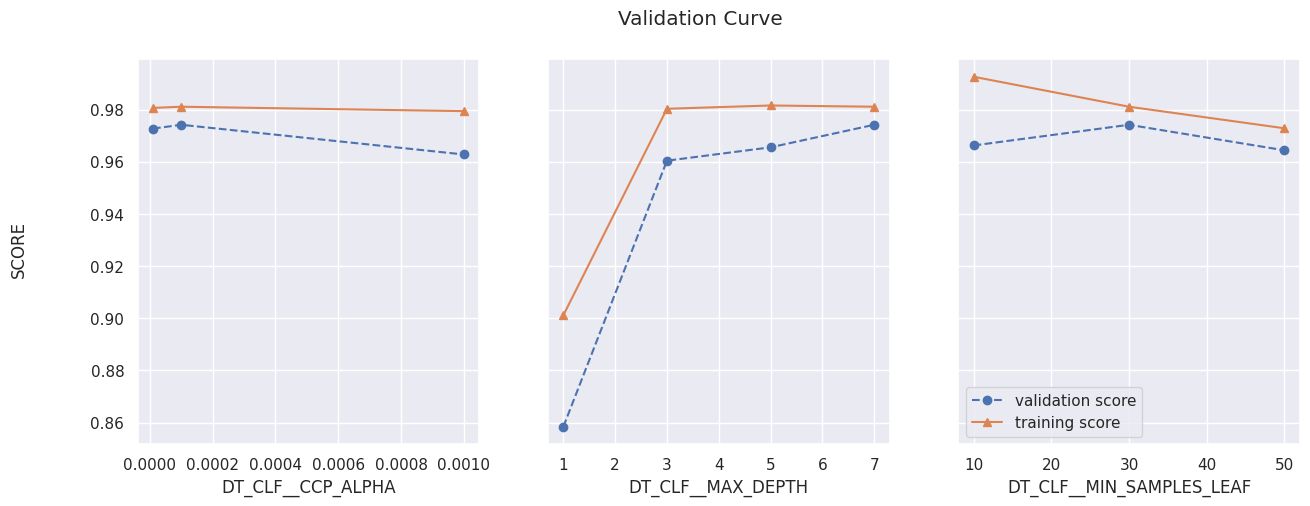

In [ ]:
# 튜닝결과 그래프
results = dt_gs.cv_results_
means_test = results['mean_test_score']
means_train = results['mean_train_score']

masks = []
masks_names = list(dt_gs.best_params_.keys())
for p_k, p_v in dt_gs.best_params_.items():
    masks.append(list(results['param_'+p_k].data==p_v))

params = dt_gs.param_grid

fig, ax = plt.subplots(1,len(params),
                       sharex='none',
                       sharey='all',
                       figsize=(15,5))
fig.suptitle('Validation Curve')
fig.text(0.04, 0.5, 'SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}

for i, p in enumerate(masks_names):
    m = np.stack(masks[:i] + masks[i+1:])
    pram_preformace_in_best
    best_parms_mask = m.all(axis=0)
    best_index = np.where(best_parms_mask)[0]
    x = np.array(params[p])
    y_1 = np.array(means_test[best_index])
    y_2 = np.array(means_train[best_index])
    ax[i].errorbar(x, y_1, linestyle='--', marker='o', label='validation score')
    ax[i].errorbar(x, y_2, linestyle='-', marker='^',label='training score' )
    ax[i].set_xlabel(p.upper())

plt.legend()
plt.show()

### 8.3 best 모델 설정

In [ ]:
# best 모델 파라미터 확인
print(dt_gs.best_score_)
print(dt_gs.best_params_)

0.9741523809523809
{'dt_clf__ccp_alpha': 0.0001, 'dt_clf__max_depth': 7, 'dt_clf__min_samples_leaf': 30}


In [ ]:
# best 모델 파라미터를 최종모델로 훈련
best_clf = dt_gs.best_estimator_
best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['반지름', '질감', '주변부', '크기',
                                                   '평활도', '조밀성', '오목', '대칭',
                                                   '프랙탈']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('smote', SMOTE(sampling_strategy=0.75)),
                ('dt_clf',
                 DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=7,
                                        min_samples_leaf=30))])

In [ ]:
print(best_clf['dt_clf'])

DecisionTreeClassifier(ccp_alpha=0.0001, max_depth=7, min_samples_leaf=30)


### 8.4 중요변수확인

In [ ]:
# 중요도 점수 계산
# tree 모형은 .coef -> .feature_importances_ 로 수정

feature = best_clf['preprocessor'].get_feature_names_out()    # 수정
importances = best_clf["dt_clf"].feature_importances_         # 수정
importances = importances.flatten()                           # flatten() - 다차원 array를 1차원 array로 변환
output = pd.DataFrame([feature , importances],
                      index = ["feature","importances"]).T
# output = output[output.importances > 0]
output.sort_values(["importances"],
                   ascending = False ,                         #ascending = False
                   inplace = True)


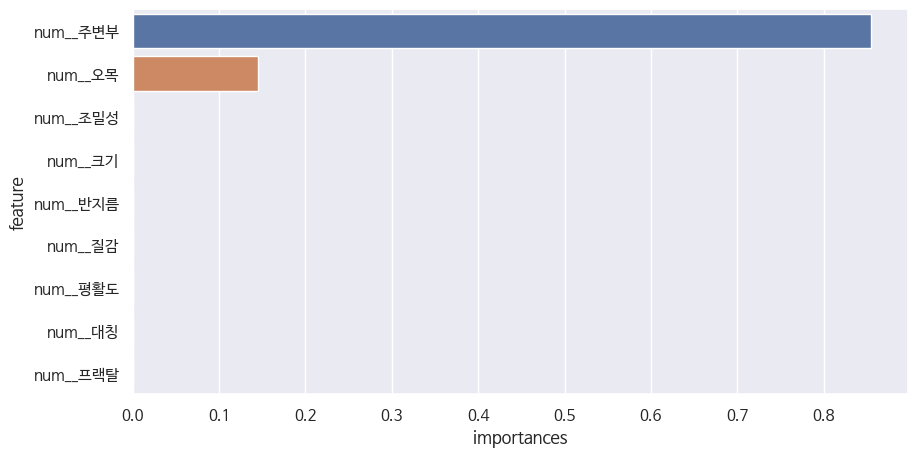

In [ ]:
# 그래프 그리기

plt.rc('font', family='NanumBarunGothic')

fig ,ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale = 1)
ax = sns.barplot(y="feature", x="importances", data=output)
plt.show()

### 8.5 훈련 결과 DT 확인

In [ ]:
# feature name과 class name 설정
feature_names = feature.tolist()        # list 형태로 수정
class_names = np.array(['악성', '양성'])

print(feature_names)
print(class_names)

['num__반지름', 'num__질감', 'num__주변부', 'num__크기', 'num__평활도', 'num__조밀성', 'num__오목', 'num__대칭', 'num__프랙탈']
['악성' '양성']


In [ ]:
from sklearn.tree import export_text

r = export_text(best_clf["dt_clf"],
                feature_names=feature_names)
print(r)

|--- num__주변부 <= 96.56
|   |--- num__오목 <= 0.10
|   |   |--- num__주변부 <= 88.85
|   |   |   |--- num__조밀성 <= 0.10
|   |   |   |   |--- class: 1
|   |   |   |--- num__조밀성 >  0.10
|   |   |   |   |--- class: 1
|   |   |--- num__주변부 >  88.85
|   |   |   |--- class: 1
|   |--- num__오목 >  0.10
|   |   |--- class: 0
|--- num__주변부 >  96.56
|   |--- num__오목 <= 0.10
|   |   |--- class: 0
|   |--- num__오목 >  0.10
|   |   |--- num__크기 <= 808.14
|   |   |   |--- class: 0
|   |   |--- num__크기 >  808.14
|   |   |   |--- class: 0



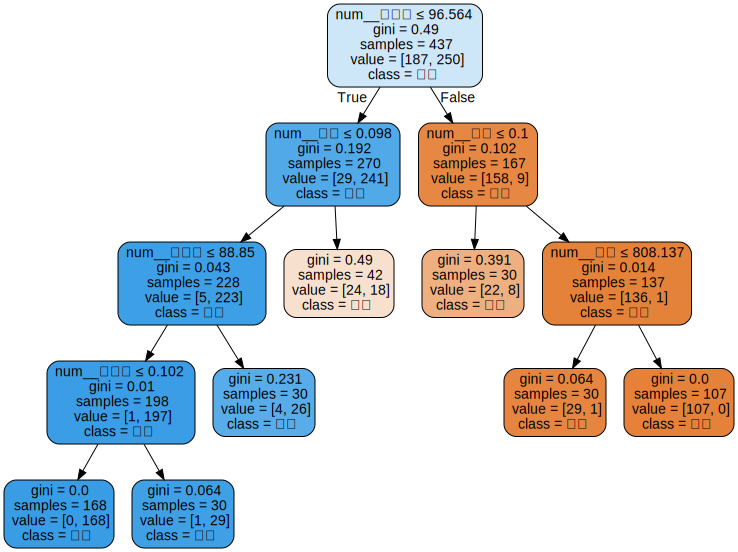

In [ ]:
# Decision tree 그래프로 확인
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(best_clf["dt_clf"],
                                out_file = None,
                                feature_names = feature_names,
                                class_names = class_names,      # 추가
                                filled = True,
                                rounded = True,
                                special_characters = True)
graph = graphviz.Source(dot_data)
graph

## 9.모델 test 및 검정

### 9.1 검증용 데이터로 예측
- predict_proba (확률값으로 표시): 분류모델에서 사용
- predict (class로 표시)

In [ ]:
y_pred = best_clf.predict_proba(X_test)
y_pred

array([[1.        , 0.        ],
       [0.13333333, 0.86666667],
       [0.        , 1.        ],
       [0.96666667, 0.03333333],
       [0.73333333, 0.26666667],
       [0.73333333, 0.26666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.73333333, 0.26666667],
       [0.96666667, 0.03333333],
       [0.73333333, 0.26666667],
       [0.57142857, 0.42857143],
       [0.73333333, 0.26666667],
       [0.03333333, 0.96666667],
       [0.        , 1.        ],
       [0.96666667, 0.03333333],
       [0.03333333, 0.96666667],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.13333333, 0.86666667],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.73333333, 0.26666667],
       [0.        , 1.        ],
       [0.57142857, 0.42857143],
       [0.        , 1.        ],
       [1.

In [ ]:
y_pred = best_clf.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

### 9.2 정오분류표 검정

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels = best_clf.classes_)
cm

array([[59,  4],
       [16, 91]])

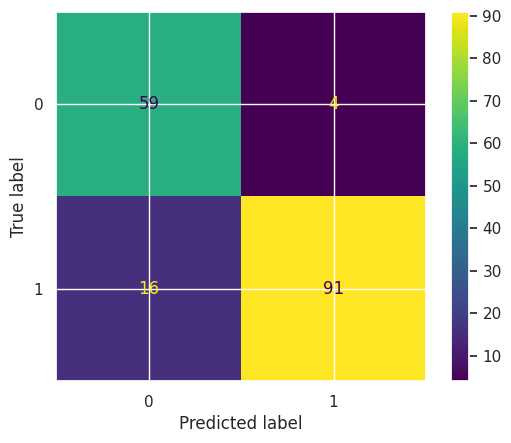

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_clf.classes_)
disp.plot()
plt.show()

### 9.3 모델 검정

In [ ]:
## 6.모델검정
#from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
#from sklearn.metrics import ConfusionMatrixDisplay # 그래프 그리기기
#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score  # 정확도, 민감도 등
#from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        63
           1       0.96      0.85      0.90       107

    accuracy                           0.88       170
   macro avg       0.87      0.89      0.88       170
weighted avg       0.89      0.88      0.88       170



In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())
print('roc_auc: %.3f' % roc_auc_score(y_test, y_pred))
print('정확도: %.3f' % accuracy_score(y_test, y_pred))
print('정밀도: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('재현율: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

잘못 분류된 샘플 개수: 20
roc_auc: 0.893
정확도: 0.882
정밀도: 0.958
재현율: 0.850
F1: 0.901


### 9.4 ROC 곡선 그리기

In [ ]:
# fpr, tpr, thresholds = roc_curve(y_test, best_clf.decision_function(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])

In [ ]:
fpr, tpr, thresholds

(array([0.        , 0.04761905, 0.04761905, 0.06349206, 0.19047619,
        0.38095238, 0.52380952, 1.        ]),
 array([0.        , 0.64485981, 0.78504673, 0.85046729, 0.91588785,
        0.97196262, 1.        , 1.        ]),
 array([2.        , 1.        , 0.96666667, 0.86666667, 0.42857143,
        0.26666667, 0.03333333, 0.        ]))

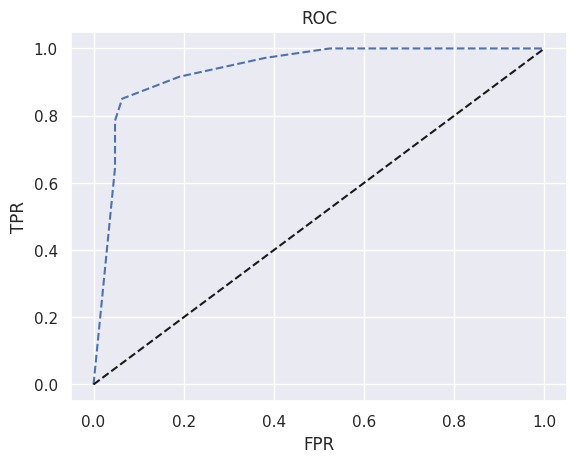

In [ ]:
plt.plot(fpr, tpr, '--', label="Decision tree")          # 수정
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC CURVE')
plt.show()

### 9.5 gain and lift chart
- scikit-plot 설치 및 사용
- https://scikit-plot.readthedocs.io/en/stable/metrics.html
- pip install scikit-plot

In [ ]:
pip install scikit-plot

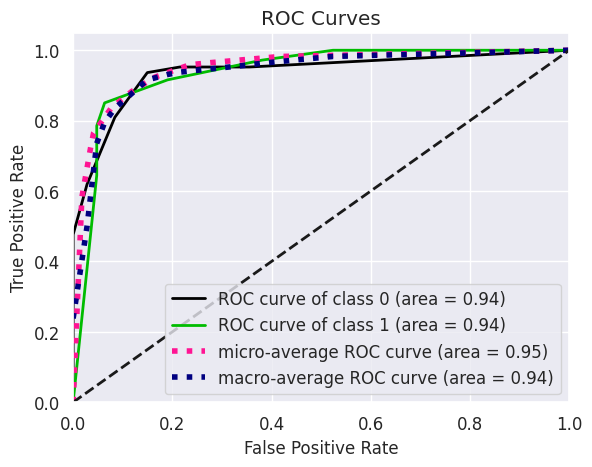

In [ ]:
# ROC_ACU Cruve
import scikitplot as skplt
skplt.metrics.plot_roc(y_test,
                       best_clf.predict_proba(X_test))
plt.show()

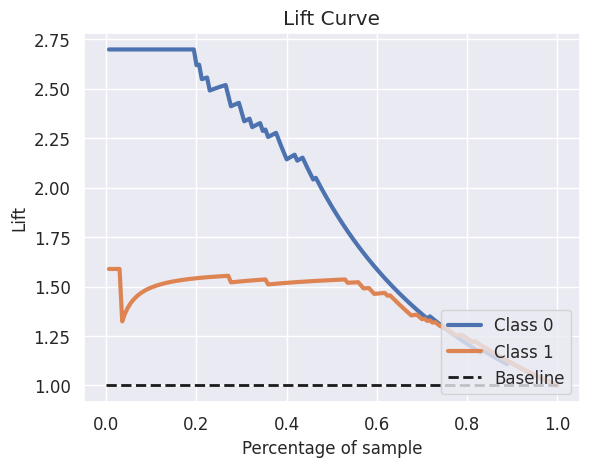

In [ ]:
# lift Chart
skplt.metrics.plot_lift_curve(y_test,
                              best_clf.predict_proba(X_test))
plt.show()

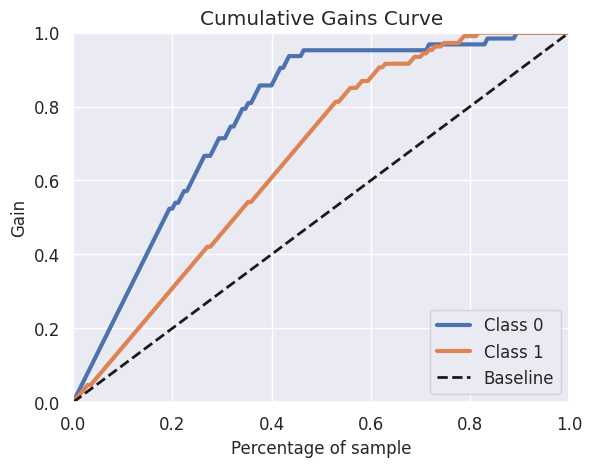

In [ ]:
# gain Chart
skplt.metrics.plot_cumulative_gain(y_test,
                                   best_clf.predict_proba(X_test))
plt.show()